# Fusing convolutional and batchnorm layers in TensorFlow

- Batchnorm layers can be fused with preceding 2D convolutional layers, into a single convolutional layer.
- Batchnorm layers *cannot* be fused with subseqeunt 2D convolutional layers, into a single convolutional layer, *if* that convolutional layer adds padding to its input.
- This script demos both types of fusion, and highlights how the fusion can fail in the latter case when padding is used.
- Thus, in some models implemented on specialized hardware (e.g., Edge TPU), it is desirable (necessary!) to have an API that implements a batchnorm layer, or at least the broadcasted scaling and shifting that can mimic a static batchnorm layer after training. Moreover, in the case of a sequence of (Conv2D->RELU->BN) layers, the batchnorm layer clearly cannot be fused with the convolutional layer and implementation as broadcast multiplies and additions would be beneficial.

Batchnorm layers scale and shift the input data, providing normalized data to the subsequent layer. In the original batchnorm [publication](https://arxiv.org/abs/1502.03167), bathnorm layers follow convolutional layers, and precede RELU layers (Conv2D->BN->RELU). Since that publication, many researchers have used batchnorm layers that follow the RELU layer (Conv2D->RELU->BN), claiming superior results.

After training, if the moving mean and moving standard deviation of the batchnorm layer are kept fixed, then the scaling and shifting parameters *might* be "fused" with a preceding or subsequent convolutional layer (by scaling and shifting the parameters of the convolutional layer), thereby allowing the explicit batchnorm layer to be removed (as it will be implicitly implemented by the convolutional layer).

For a nice summary of how this fusing can be accomplished when the batchnorm layer follows the convolutional layer, see here: [https://tehnokv.com/posts/fusing-batchnorm-and-conv/](https://tehnokv.com/posts/fusing-batchnorm-and-conv/).

*However*, if the batchnorm precedes a convolutional layer, the fusion can only be accomplished if the convolutional layer does not add any padding to the input. If padding is added, attempts to fuse the batchnorm layer will results in errors at the edges of the output tensors, compared to outputs of the unfused pair of layers. This discrepency will be demo'd in this script.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, BatchNormalization
from tensorflow.keras import Model

# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

### Define the architectures that will be used

In [2]:
def build_conv_bn(input_shape, n_chan_out, padding='same'):
    # Build architecture with batchnorm after convolution
    x = Input(shape=input_shape)
    y = Conv2D(n_chan_out, (3,3), padding=padding, name='paired_conv_1')(x)
    y = BatchNormalization(axis=-1, name='paired_bn_1', fused=False,
                           beta_initializer=tf.initializers.RandomUniform(0, 1),
                           gamma_initializer=tf.initializers.RandomNormal(0, 0.5),
                           moving_mean_initializer=tf.initializers.RandomNormal(0, 0.5),
                           moving_variance_initializer=tf.initializers.RandomUniform(0, 1))(y)
    model = Model(x, y)
    return model

def build_bn_conv(input_shape, n_chan_out, padding='same'):
    # Build architecture with batchnorm before convolution
    x = Input(shape=input_shape)
    y = BatchNormalization(axis=-1, name='paired_bn_1', fused=False,
                           beta_initializer=tf.initializers.RandomUniform(0, 1),
                           gamma_initializer=tf.initializers.RandomNormal(0, 0.5),
                           moving_mean_initializer=tf.initializers.RandomNormal(0, 0.5),
                           moving_variance_initializer=tf.initializers.RandomUniform(0, 1))(x)
    y = Conv2D(n_chan_out, (3,3), padding=padding, name='paired_conv_1')(y)
    model = Model(x, y)
    return model

def build_fused(input_shape, n_chan_out, padding='same'):
    # Build fused architecture (one without the explicit batchnorm layer)
    x = Input(shape=input_shape)
    y = Conv2D(n_chan_out, (3,3), padding=padding, name='fused_conv_1')(x)
    model = Model(x, y)
    return model

### Define methods for setting parameters of the fused models

#### Fusion of convolution followed by batchnorm
In this case, the fusion is fairly straightforward. We compute the new parameters
of the resulting convolutional layer as follows. (Abusing notation by aggregating
the convolutional parameters into a single ```w``` variable, and indicting the
convolution operater as ```**``` and the multiply operator as ```*```.)

 - For convolution we have:
     - ```y = w_conv**x + b_conv```
 - For batchnorm we have:
     - ```z = m_bn*y + b_bn```
 - Combining we get:
     - ```z = m_bn*(w_conv**x + b_conv) + b_bn```
     - ```z = (m_bn*w_conv)**x + (m_bn*b_conv + bn)```
 - So:
     - ```w_fuse = m_bn * w_conv```
     - ```b_fuse = m_bn * b_conv + b_bn```
     - ```z = w_fuse*x + b_fuse```
     
     
#### Fusion of batchnorm followed by convolution
In this case, the inclusion of the offset (shift) parameter in the batchnorm
can cause problems if padding is used.

 - For batchnorm we have:
     - ```y = m_bn*x + b_bn```
 - For convolution we have:
     - ```z = w_conv**y + b_conv```
 - Combining we get:
     - ```z = w_conv**(m_bn*x + b_bn) + b_conv```
     - ```z = (w_conv*m_bn)**x + w_conv**b_bn + b_conv```

But the above "combined" equations are not as simple as they appear. The new convolution kernel, ```w_conv*m_bn``` is fine as it is. But the ```w_conv**b_bn``` portion of the new bias term needs further
explanation. Because the batchnorm shift parameter is added before the convolution is applied, we must sum all the weights and multiply them by the shift parameter, which is not be clear from the notation.

 - The new bias term is really this:
     - ```SUM_ij[w_conv_ij]*b_bn + b_conv```

The problem occurs when zero padding is added to the input to the convolution layer. In that case, the new zero values have not had the shift of the batchnorm layer added to them (the scaling parameter doesn't matter, since it would have been multipled by zero, had the zero-padding been applied before the batchnorm layer rather than after it). But we'll plow ahead anyway...

 - So:
     - ```w_fuse = w_conv * m_bn```
     - ```b_fuse = SUM_ij[w_conv_ij]*b_bn + b_conv```
     - ```z = w_fuse*x + b_fuse```


In [3]:
def fuse_conv_bn_params(model_source, model_target):
    names = [layer.name for layer in model_source.layers]
    for name in names:
        # Assume names have fixed prefix, but model-specific
        # suffixes for multiple conv-bn layer pairs.
        if name.startswith('paired_bn'):
            name_bn = name
            name_conv = 'paired_conv' + name[len('paired_bn'):]
            name_fuse = 'fused_conv' + name[len('paired_bn'):]

            ## Get effective scaling and shifting parameters of the batchnorm
            layer_bn = model_source.get_layer(name=name_bn)
            params_bn = layer_bn.get_weights()
            gamma = params_bn[0]
            beta = params_bn[1]
            moving_mean = params_bn[2]
            moving_variance = params_bn[3]
            epsilon = layer_bn.epsilon

            m_bn = gamma / np.sqrt(moving_variance + epsilon)
            b_bn = beta - m_bn * moving_mean

            ## Get weight and bias parameters of the convolution
            layer_conv = model_source.get_layer(name=name_conv)
            params_conv = layer_conv.get_weights()
            w_conv = params_conv[0]
            b_conv = params_conv[1]

            ## Compute new convolution kernel and bias of composite layer/model            
            # Need to be sure we broadcast across correct dimensions
            b_fuse = m_bn * b_conv + b_bn
            m_bn = np.reshape(m_bn, (1, 1, 1,  m_bn.size))
            w_fuse = m_bn * w_conv

            ## Set parameters for composite layer/model
            layer_fuse = model_target.get_layer(name=name_fuse)
            layer_fuse.set_weights([w_fuse, b_fuse])

def fuse_bn_conv_params(model_source, model_target):
    names = [layer.name for layer in model_source.layers]
    for name in names:
        # Assume names have fixed prefix, but model-specific
        # suffixes for multiple conv-bn layer pairs.
        if name.startswith('paired_bn'):
            name_bn = name
            name_conv = 'paired_conv' + name[len('paired_bn'):]
            name_fuse = 'fused_conv' + name[len('paired_bn'):]

            ## Get effective scaling and shifting parameters of the batchnorm
            layer_bn = model_source.get_layer(name=name_bn)
            params_bn = layer_bn.get_weights()
            gamma = params_bn[0]
            beta = params_bn[1]
            moving_mean = params_bn[2]
            moving_variance = params_bn[3]
            epsilon = layer_bn.epsilon

            m_bn = gamma / np.sqrt(moving_variance + epsilon)
            b_bn = beta - m_bn * moving_mean

            ## Get weight and bias parameters of the convolution
            ## Compute new convolution kernel of composite layer/model
            layer_conv = model_source.get_layer(name=name_conv)
            params_conv = layer_conv.get_weights()
            w_conv = params_conv[0]
            b_conv = params_conv[1]

            ## Compute new convolution kernel and bias of composite layer/model

            # New convolutional kernel...
            m_bn = np.reshape(m_bn, (1, 1, m_bn.size, 1))
            w_fuse = w_conv * m_bn
            
            # New bias...
            # Mimic impact of convolution on the shift/offset term of the batchnorm.
            # This is slightly incorrect at the x/y spatial edges of the tensors if
            # conv padding is used.
            
            # b_bn has no x/y spatial dependence, so sum conv weights in x and y...
            w_conv_sum = np.sum(w_conv, axis=(0,1))
            # mimic the convolution, applied to the shifting parameter of the batchnorm
            b_bnconv = np.sum(w_conv_sum * np.reshape(b_bn, (b_bn.size, 1)), axis=0)
            b_fuse = b_conv + b_bnconv
           
            # Set parameters for composite layer/model
            layer_fuse = model_target.get_layer(name=name_fuse)
            layer_fuse.set_weights([w_fuse, b_fuse])

### Set model input/output sizes, and create random input sample for testing

In [4]:
# Set the seed, for repeatability
tf.random.set_seed(0)

input_shape = (20, 20, 3)
n_chan_out = 16 # Unimportant. Will sum over all output channels for plotting

# Create random data for model testing through models and measure the output delta
n_samples = 1
x = tf.random.normal([n_samples] + list(input_shape))

### Build and test fused models: Convolution (with padding) followed by batchnorm
Note that the output errors (difference) between the two models is just numerical accuracy error, which is very small.

Mean Absolute Error: 5.26e-08


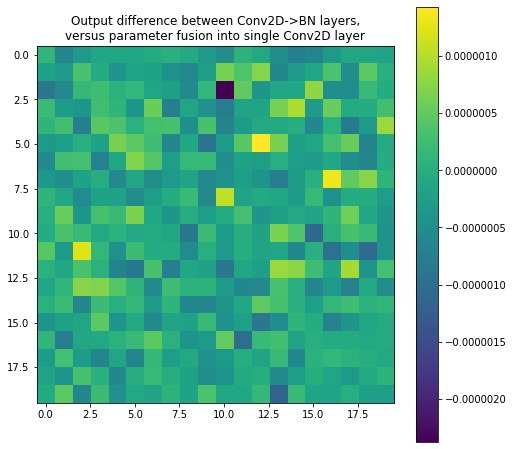

In [5]:
# Build models with random parameters
padding = 'same' # same or valid
model_conv_bn = build_conv_bn(input_shape, n_chan_out, padding=padding)
model_fused = build_fused(input_shape, n_chan_out, padding=padding)

# Fused conv+batchnorm parameters into new conv parameters
fuse_conv_bn_params(model_conv_bn, model_fused)

# Put data through both models and measure the output delta
y_conv_bn = model_conv_bn.predict(x)
y_fused = model_fused.predict(x)

delta = y_conv_bn - y_fused
mae = np.mean(np.absolute(delta))
print('Mean Absolute Error: %0.2e' % (mae))

# Show delta
delta = delta[0]
delta = np.sum(delta, axis=2) # Sum over all output channels for plotting

plt.figure(figsize=(8, 8))
plt.subplot()
plt.imshow(delta, aspect='equal')
plt.colorbar()
_ = plt.title('Output difference between Conv2D->BN layers,\nversus parameter fusion into single Conv2D layer')

### Build and test fused models: Batchnorm followed by convolution (*with* padding)
Note that edge errors occur when padding is added to the tensor after the batchnorm, but before the convolution.

Mean Absolute Error: 3.85e-02


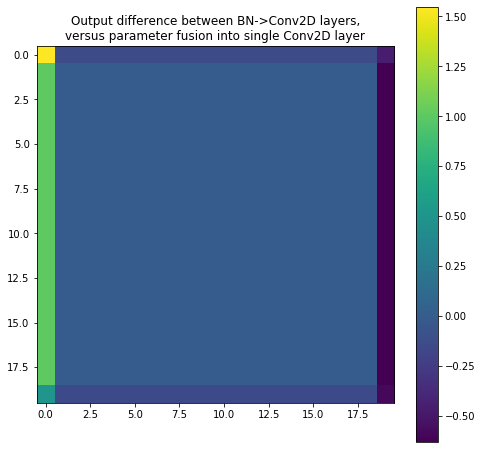

In [6]:
# Build models with random parameters
padding = 'same' # same or valid
model_bn_conv = build_bn_conv(input_shape, n_chan_out, padding=padding)
model_fused = build_fused(input_shape, n_chan_out, padding=padding)

# Fused conv+batchnorm parameters into new conv parameters
fuse_bn_conv_params(model_bn_conv, model_fused)

# Put data through both models and measure the output delta
y_bn_conv = model_bn_conv.predict(x)
y_fused = model_fused.predict(x)

delta = y_bn_conv - y_fused
mae = np.mean(np.absolute(delta))
print('Mean Absolute Error: %0.2e' % (mae))

# Show delta
delta = delta[0]
delta = np.sum(delta, axis=2) # Sum over all output channels for plotting

plt.figure(figsize=(8, 8))
plt.subplot()
plt.imshow(delta, aspect='equal')
plt.colorbar()
_ = plt.title('Output difference between BN->Conv2D layers,\nversus parameter fusion into single Conv2D layer')

### Build and test fused models: Batchnorm followed by convolution (*without* padding)
In this case there is no edge effect error, since padding is not used.

Mean Absolute Error: 4.14e-08


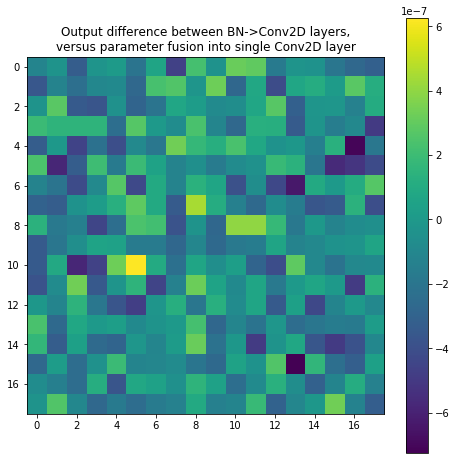

In [7]:
# Build models with random parameters
padding = 'valid' # same or valid
model_bn_conv = build_bn_conv(input_shape, n_chan_out, padding=padding)
model_fused = build_fused(input_shape, n_chan_out, padding=padding)

# Fused conv+batchnorm parameters into new conv parameters
fuse_bn_conv_params(model_bn_conv, model_fused)

# Put data through both models and measure the output delta
y_bn_conv = model_bn_conv.predict(x)
y_fused = model_fused.predict(x)

delta = y_bn_conv - y_fused
mae = np.mean(np.absolute(delta))
print('Mean Absolute Error: %0.2e' % (mae))

# Show delta
delta = delta[0]
delta = np.sum(delta, axis=2) # Sum over all output channels for plotting

plt.figure(figsize=(8, 8))
plt.subplot()
plt.imshow(delta, aspect='equal')
plt.colorbar()
_ = plt.title('Output difference between BN->Conv2D layers,\nversus parameter fusion into single Conv2D layer')